In [ ]:
#50. データの入手・整形
#News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．
#ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
#情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
#抽出された事例をランダムに並び替える．
#抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
#学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

"""
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip /content/NewsAggregatorDataset.zip
"""
#出版社のリストとカラムの名前を定義

#抽出したい出版社のリスト
extract_list = ['Reuters', 'Huffington Post',
                'Businessweek', 'Contactmusic.com', 'Daily Mail']

#CSVファイルのカラム名のリスト
header_name = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'
               ]

#元のデータを見るとheaderなし、分割はタブ、headerの名前はheader_nameリストの中身を割り当て
df = pd.read_csv('newsCorpora.csv', header=None,sep='\t', names=header_name)

# dfの'PUBLISHER'の要素がextract_listの要素であるとき、'TITLE'と'CATEGORY'を抽出
#pandas.Series.isin()メソッド：DataFrameの条件抽出/戻り値はbool型。引数に取得したい要素を指定
#df[“列名”]：DataFrameの列を抽出
df_extracted = df.loc[df['PUBLISHER'].isin(extract_list),['TITLE', 'CATEGORY']]

#学習、検証、評価データに分割
#sklearn.model_selection.train_test_split()関数：データセットの分割
#                                               引数test_size：テスト用データの割合を指定
#
#                                               random_state：乱数のシードを指定するためのパラメータ/再現性のために使用
#　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　(shuffle=Trueというのもあるらしい)

data_train, data_other = train_test_split(df_extracted, test_size=0.2, random_state=20010101)
data_valid, data_test = train_test_split(data_other, test_size=0.5, random_state=20010101)


data_train.to_csv("train.txt", sep="\t", index=False)
data_valid.to_csv("valid.txt", sep="\t", index=False)
data_test.to_csv("test.txt", sep="\t", index=False)

print("train_data")
print(data_train['CATEGORY'].value_counts())
print("valid_data")
print(data_valid['CATEGORY'].value_counts())
print("test_data")
print(data_test['CATEGORY'].value_counts())

train_data
CATEGORY
b    4495
e    4242
t    1207
m     728
Name: count, dtype: int64
valid_data
CATEGORY
b    586
e    496
t    168
m     84
Name: count, dtype: int64
test_data
CATEGORY
b    546
e    541
t    149
m     98
Name: count, dtype: int64


In [ ]:
import pandas as pd
import string
import re

from sklearn.feature_extraction.text import CountVectorizer #BoW
from sklearn.feature_extraction.text import TfidfVectorizer #tf-idf



#作業２：前処理の関数化
def prep(text):
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = text.lower()  # 小文字化
    text = re.sub("[0-9]+", "", text)  # 1つ以上の数字を""で置換
    return text

#作業３：テキストファイル読み込み
header_name = ['TITLE', 'CATEGORY'] #元のデータにはヘッダーがないので新ヘッダー名をリストにまとめておく

train = pd.read_csv("./train.txt", header=None,
                    sep='\t', names=header_name)
valid = pd.read_csv('./valid.txt', header=None,
                    sep='\t', names=header_name)
test = pd.read_csv('./test.txt', header=None,
                   sep='\t', names=header_name)


#作業４：データの結合,前処理関数適用
df = pd.concat([train, valid, test], axis=0)    #concat([連結するDataFrame、Series(表1列) #カンマ区切り], axis=0 #縦方向)
df.reset_index(drop=True, inplace=True) #drop=True：元のインデックス列を削除(DataFrameのサイズ削減)
                                        #inplace=True:元のDataFrameを直接変更(デフォルトだと元のDataFrameを変更し、新しいDataFrameを返す）


df["TITLE"] = df["TITLE"].apply(prep)#無名関数lambda：1つの引数 x を受け取り、prep()関数に渡す

#作業５：データ分割、特徴量抽出
train_valid_data = df[:len(train)+len(valid)] #トレーニングデータと検証データの合計行数までの行をtrain_valid_dに割り当て
test_data = df[len(train)+len(valid):]

vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2)) #min_df：dfの最小値を設定
                                                           #n_gram_range：使用するn_gramを1~2gramに設定



# fit_transform：fitの計算とtransformの計算を連続で実行
# testのデータを用いずに統計量を獲得し，testはfitで得られた統計量に基づき正則化
# testのデータを含めてfitすると，テストデータを用いて学習しているため不適

#作業６：統計量の正規化、データフレームに変換、それぞれファイルに保存

train_valid_f = vec_tfidf.fit_transform(train_valid_data["TITLE"]) #fit_transform()：統計量を計算し、その統計量に基いて()の中身を正規化
test_f = vec_tfidf.transform(test_data["TITLE"]) # transform()：既に計算された統計量を再利用し、正規化

train_valid_vec = pd.DataFrame(train_valid_f.toarray(), columns=vec_tfidf.get_feature_names_out()) #列：特徴量、行：タイトル
test_vec = pd.DataFrame(test_f.toarray(), columns=vec_tfidf.get_feature_names_out())

train_vec = train_valid_vec[:len(train)]
valid_vec = train_valid_vec[len(train):len(train)+len(valid)]

train_vec.to_csv("train.feature.txt", sep="\t", index=False)
valid_vec.to_csv("valid.feature.txt", sep="\t", index=False)
test_vec.to_csv("test.feature.txt", sep="\t", index=False)

#作業７：特徴ベクトルの表示
print(train_vec.head())

    aa  aaliyah  abbvie  abc     about  about the  about to  above  abramson  \
0  0.0      0.0     0.0  0.0  0.274053        0.0       0.0    0.0       0.0   
1  0.0      0.0     0.0  0.0  0.000000        0.0       0.0    0.0       0.0   
2  0.0      0.0     0.0  0.0  0.000000        0.0       0.0    0.0       0.0   
3  0.0      0.0     0.0  0.0  0.000000        0.0       0.0    0.0       0.0   
4  0.0      0.0     0.0  0.0  0.000000        0.0       0.0    0.0       0.0   

   abuse  ...  young  your  your mother   yr  yr high  yuan  zac  zac efron  \
0    0.0  ...    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0   
1    0.0  ...    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0   
2    0.0  ...    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0   
3    0.0  ...    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0   
4    0.0  ...    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0   

   zendaya  zone  
0      0.0   0.0  
1     

In [ ]:
#52. 学習
#51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

import pandas as pd
from sklearn.linear_model import LogisticRegression
import pickle

#ロジスティック回帰モデルのインスタンスを作成
#random_state=20010101: モデルのランダムな動作を固定して再現性を確保
#max_iter：最大の反復回数
lr = LogisticRegression(random_state=20010101, max_iter=1000)

#train_data = pd.read_table("train.txt")
#print(train_data.head())
#トレーニングデータ読み込み

X_train = pd.read_table("train.feature.txt") #特徴量
Y_train = pd.read_table("train.txt")["CATEGORY"] #カテゴリ情報

#モデルのトレーニング
lr.fit(X_train, Y_train)

#モデルの保存(予測の際に使用)
with open("logreg.pkl", "wb") as f:
    pickle.dump(lr, f)


In [ ]:
#53
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
import pandas as pd

#score_lr関数:与えられたロジスティック回帰モデルと入力データに対し、予測確率とクラスラベルの両方を返す
def score_lr(lr, x):
    return [np.max(lr.predict_proba(x), axis=1), lr.predict(x)]

#logreg.pklから保存されたロジスティック回帰モデルを読み込む
lr = pickle.load(open("logreg.pkl", 'rb'))

#train.feature.txtとtest.feature.txtからトレーニングデータとテストデータを読み込む
X_train = pd.read_table("train.feature.txt")
X_test = pd.read_table("test.feature.txt")

#train.txtとtest.txtからトレーニングデータ、テストデータの正解ラベル読み込み
train = pd.read_table("train.txt")
test = pd.read_table("test.txt")

#score_lr関数でトレーニングデータセットとテストデータセットのそれぞれに対して予測
train_pred = score_lr(lr, X_train)
test_pred = score_lr(lr, X_test)

if __name__ == "__main__":
    print(train_pred)

"""
[array([0.95639054, 0.95150829, 0.7172343 , ..., 0.41618661, 0.79069576,
       0.40435474]), array(['e', 'e', 't', ..., 'b', 'b', 'b'], dtype=object)]

"""

[array([0.9732477 , 0.53978695, 0.98879519, ..., 0.78730501, 0.8779636 ,
       0.37224871]), array(['e', 'e', 'e', ..., 'b', 'b', 'e'], dtype=object)]


"\n[array([0.95639054, 0.95150829, 0.7172343 , ..., 0.41618661, 0.79069576,\n       0.40435474]), array(['e', 'e', 't', ..., 'b', 'b', 'b'], dtype=object)]\n\n"

In [ ]:
#５４．
from sklearn.metrics import accuracy_score
#from knock53 import *

# 訓練データの正解率を計算
train_acc = accuracy_score(train["CATEGORY"], train_pred[1])

# accuracy_score：テストデータの正解率を計算
test_acc = accuracy_score(test["CATEGORY"], test_pred[1])

print(f"訓練データの正解率:{train_acc:.3f}")
print(f"テストデータの正解率:{test_acc:.3f}")

訓練データの正解率:0.920
テストデータの正解率:0.870


訓練データの混同行列
[[4331  101   11   52]
 [  69 4161    3    9]
 [ 107  129  479   13]
 [ 214  143    6  844]]
テストデータの混同行列
[[506  26   3  11]
 [ 13 524   1   3]
 [ 23  27  46   2]
 [ 39  21   5  84]]


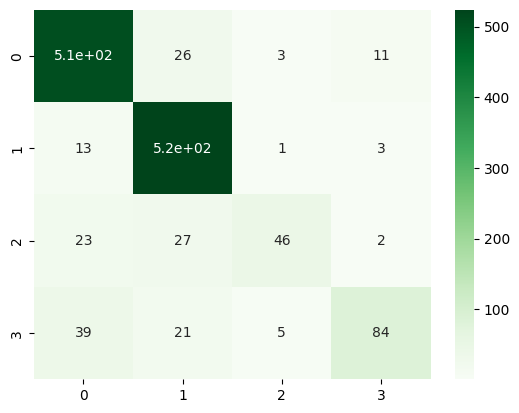

In [ ]:
#５５
from sklearn.metrics import confusion_matrix
#from knock53 import *
import seaborn as sns
import matplotlib.pyplot as plt

#混合行列を計算
train_con = confusion_matrix(train["CATEGORY"], train_pred[1])
test_con = confusion_matrix(test["CATEGORY"], test_pred[1])

# 混同行列を表示
print("訓練データの混同行列")
print(train_con)
print("テストデータの混同行列")
print(test_con)

# 訓練データの混同行列をヒートマップとして保存
sns.heatmap(train_con, annot=True, cmap="Greens")
plt.savefig("train_confusion_matrix.png")
# 現在の図をクリア
plt.clf()

# テストデータの混同行列をヒートマップとして保存
sns.heatmap(test_con, annot=True, cmap="Greens")
plt.savefig("test_confusion_matrix.png")



In [ ]:
#56. 適合率，再現率，F1スコアの計測
#52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．
#カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

from sklearn.metrics import *
#from knock53 import *

print(classification_report(test["CATEGORY"], test_pred[1]))


              precision    recall  f1-score   support

           b       0.87      0.93      0.90       546
           e       0.88      0.97      0.92       541
           m       0.84      0.47      0.60        98
           t       0.84      0.56      0.67       149

    accuracy                           0.87      1334
   macro avg       0.86      0.73      0.77      1334
weighted avg       0.87      0.87      0.86      1334



In [ ]:
#57. 特徴量の重みの確認
#52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

from sklearn.metrics import *
#from knock53 import *
import numpy as np

feat = X_train.columns.values
ind = [i for i in range(1, 11)]
for c, coef in zip(lr.classes_, lr.coef_):
    top10 = pd.DataFrame(feat[np.argsort(-coef)[:10]],
                         columns=[f"top10 : {c}"], index=ind)
    worst10 = pd.DataFrame(feat[np.argsort(coef)[:10]], columns=[
                           f"worst10 : {c}"], index=ind)
    print(f"{c}'s weight")
    print(top10)
    print(worst10)

b's weight
    top10 : b
1        bank
2         fed
3         ecb
4      stocks
5        euro
6         oil
7      profit
8       china
9     ukraine
10  obamacare
   worst10 : b
1        video
2          her
3          and
4        ebola
5           tv
6        aereo
7     facebook
8          the
9    microsoft
10       study
e's weight
     top10 : e
1        chris
2   kardashian
3        movie
4         film
5          kim
6          her
7         paul
8          she
9      trailer
10     beyonce
   worst10 : e
1           us
2       update
3       google
4        study
5         says
6      billion
7          ceo
8        china
9         data
10          gm
m's weight
   top10 : m
1      ebola
2      study
3     cancer
4        fda
5       mers
6       drug
7    doctors
8        cdc
9     health
10     cases
   worst10 : m
1           gm
2         deal
3     facebook
4      climate
5          ceo
6         bank
7        sales
8        apple
9       google
10          tv
t's weight

In [ ]:
#58. 正則化パラメータの変更
#ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．
#異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．
#実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

import pandas as pd
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


def score_lr(lr, x):
    return [np.max(lr.predict_proba(x), axis=1), lr.predict(x)]


def learning_model(x_train, y_train, c):
    lr = LogisticRegression(random_state=20010101, max_iter=1000, C=c)
    lr.fit(x_train, y_train)
    model_name = "logreg" + str(c) + ".pkl"
    with open(model_name, "wb") as f:
        pickle.dump(lr, f)
    return lr


def open_model(c):
    model_name = "logreg" + str(c) + ".pkl"
    with open(model_name, "rb") as f:
        model = pickle.load(f)
    return model


if __name__ == "__main__":
    X_train = pd.read_table("train.feature.txt")
    X_valid = pd.read_table("valid.feature.txt")
    X_test = pd.read_table("test.feature.txt")
    Y_train = pd.read_table("train.txt")["CATEGORY"]
    Y_valid = pd.read_table("valid.txt")["CATEGORY"]
    Y_test = pd.read_table("test.txt")["CATEGORY"]
    train = pd.read_table("train.txt")
    valid = pd.read_table("valid.txt")
    test = pd.read_table("test.txt")
    # 逆数が正則化項に対応するのに注意
    regular = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    train_acu = []
    valid_acu = []
    test_acu = []
    for c in regular:
        # model = learning_model(X_train, Y_train, c)
        model = open_model(c)
        train_pred = score_lr(model, X_train)
        valid_pred = score_lr(model, X_valid)
        test_pred = score_lr(model, X_test)
        train_acu.append(accuracy_score(train["CATEGORY"], train_pred[1]))
        valid_acu.append(accuracy_score(valid["CATEGORY"], valid_pred[1]))
        test_acu.append(accuracy_score(test["CATEGORY"], test_pred[1]))
    plt.plot(regular, train_acu,  marker="o", color="red", label="train")
    plt.plot(regular, valid_acu,  marker="o", color="blue", label="valid")
    plt.plot(regular, test_acu,  marker="o", color="green", label="test")
    plt.xscale("log")
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.savefig("regular_parameter")

FileNotFoundError: [Errno 2] No such file or directory: 'logreg0.0001.pkl'

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

X_train = pd.read_table("train.feature.txt")
X_valid = pd.read_table("valid.feature.txt")
X_test = pd.read_table("test.feature.txt")
Y_train = pd.read_table("train.txt")["CATEGORY"]
Y_valid = pd.read_table("valid.txt")["CATEGORY"]
Y_test = pd.read_table("test.txt")["CATEGORY"]
train = pd.read_table("train.txt")
valid = pd.read_table("valid.txt")
test = pd.read_table("test.txt")
param_grid = {'C': [i for i in range(1, 21)]}

grid_search = GridSearchCV(LogisticRegression(
    random_state=20010101, max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print("Best parameters : {}".format(grid_search.best_params_))
print("Best cross-validation score : {:.3f}".format(grid_search.best_score_))

"""
Best parameters : {'C': 5}
Best cross-validation score : 0.882
"""

Best parameters : {'C': 5}
Best cross-validation score : 0.886


"\nBest parameters : {'C': 5}\nBest cross-validation score : 0.882\n"